In [1]:
import pandas as pd
from keras import preprocessing

def constructor(path=None):
    with open(path,'r',encoding='gbk',errors='ignore') as f:  #txt为ANSI格式
        df = []
        for line in f.readlines():
            df.append(line.strip().split('\t'))
        data = pd.DataFrame(df)
        f.close()
    return data

pos = constructor('D:/娱乐交接文档/MD明星指数模型/可视化项目/mightUse/pos60000.txt')
neg = constructor('D:/娱乐交接文档/MD明星指数模型/可视化项目/mightUse/neg60000.txt')
dic = constructor('D:/娱乐交接文档/MD明星指数模型/可视化项目/mightUse/7000常用字优化版.txt')

Using TensorFlow backend.
D:\miniconda\envs\dl-pytorch-1.7.0\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\miniconda\envs\dl-pytorch-1.7.0\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\miniconda\envs\dl-pytorch-1.7.0\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\miniconda\envs\dl-pytorch-1.7.0\lib\site-packag

In [2]:
hashmap = {}
tmp = []
for i in dic.iloc[:,0]:
    for char in i:
        tmp.append(char)
for i,char in enumerate(tmp):
    hashmap[char] = i + 1

sample = '如果不使用关键字的话，你就必须调用去关闭file对象并且立即释放被占用的任何系统资源'
sample_data = []
for _ in sample:
    sample_data.append(hashmap.get(_))
sample_data = list(filter(None, sample_data)) #中文字符的，。不包含在内
print(sample_data)

[836, 1626, 202, 1744, 433, 771, 5346, 795, 1776, 2010, 1144, 4858, 484, 2555, 3577, 433, 334, 771, 766, 47, 50, 53, 46, 509, 4104, 770, 375, 457, 1341, 4808, 1885, 3566, 366, 433, 1776, 685, 1130, 1211, 2886, 3428, 5510]


In [3]:
import numpy as np
def processor(data):
    result = []
    for line in data.iloc[:,0]:
        line_list = []
        for char in line:
            idx = hashmap.get(char)
            line_list.append(idx)
        line_list = list(filter(None, line_list)) #去除未匹配元素
        result.append(line_list)
    return np.array(result)

pos_list = processor(pos)
neg_list = processor(neg)

D:\miniconda\envs\dl-pytorch-1.7.0\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [4]:
def train_data_prep(pos, neg):
    non_label = np.concatenate((pos, neg),axis=0)
    labels = np.concatenate((np.ones(len(pos),dtype=int), np.zeros(len(neg),dtype=int)))
    with_label = np.stack((non_label, labels),axis=1)
    np.random.shuffle(with_label)
    cut_idx = int(len(with_label)/2)
    (x_train, y_train),(x_test, y_test) = (with_label[0:cut_idx][:,0],with_label[0:cut_idx][:,1]),\
                                            (with_label[cut_idx:][:,0],with_label[cut_idx:][:,1])
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = train_data_prep(pos_list, neg_list)

In [5]:
maxlen = 50 #截断前50个词语
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(8000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 8)             64000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 64,401
Trainable params: 64,401
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 2s - loss: 0.3464 - acc: 0.8738 - val_loss: 0.2484 - val_acc: 0.9146
Epoch 2/10
48000/48000 [==============================] - 2s - loss: 0.2195 - acc: 0.9250 - val_loss: 0.2395 - val_acc: 0.9178
Epoch 3/10
48000/48000 [==============================] - 2s - loss: 0.2087 - acc: 0.9292 - val_loss: 0.2404 - val_acc: 0.9192
Epoch 4/10
48000/48000 [==============================] - 2s - loss: 0.2027 - acc: 0.9321 - val_loss: 0.2406 - val_acc: 0.9183
Epoch 5/10
48000/48000 [==============================] - 2s - loss: 0.1972 - acc: 0.9341 - val_loss: 0.2431 - val_acc: 0.9186
Epoch 6/10
48000/48000 [==============================] - 2s - loss: 0.1918 - acc: 0.9370 - val_loss: 0.2457 - val_acc: 0.9151
Epoch 7/10
48000/48000 [==============================] - 2s - loss: 0.1865 - acc: 0.9389 - val_loss: 0.2468 - val_acc: 0.9176
Epoch 8/10
48000/48000 [==============================] - 2s 

In [8]:
import matplotlib.pyplot as plt
def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

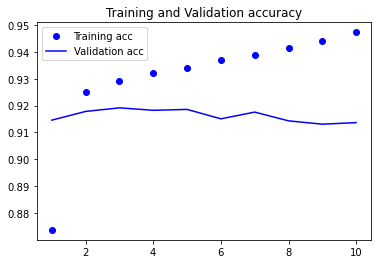

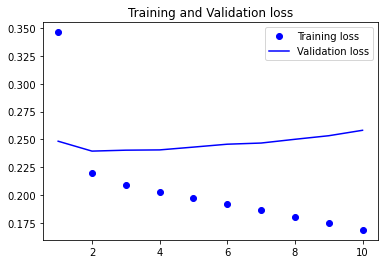

In [9]:
plot(history)

In [10]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(8000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=.2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 28s - loss: 0.3011 - acc: 0.8854 - val_loss: 0.2117 - val_acc: 0.9217
Epoch 2/10
48000/48000 [==============================] - 41s - loss: 0.1913 - acc: 0.9307 - val_loss: 0.2038 - val_acc: 0.9220
Epoch 3/10
48000/48000 [==============================] - 44s - loss: 0.1781 - acc: 0.9351 - val_loss: 0.2007 - val_acc: 0.9223
Epoch 4/10
48000/48000 [==============================] - 34s - loss: 0.1695 - acc: 0.9378 - val_loss: 0.1989 - val_acc: 0.9218
Epoch 5/10
48000/48000 [==============================] - 42s - loss: 0.1607 - acc: 0.9412 - val_loss: 0.1979 - val_acc: 0.9225
Epoch 6/10
48000/48000 [==============================] - 44s - loss: 0.1519 - acc: 0.9441 - val_loss: 0.2002 - val_acc: 0.9249
Epoch 7/10
48000/48000 [==============================] - 41s - loss: 0.1415 - acc: 0.9471 - val_loss: 0.1883

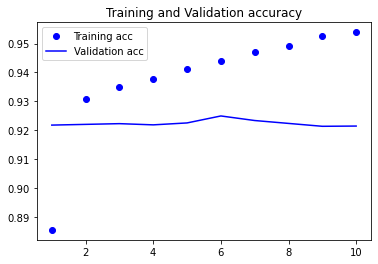

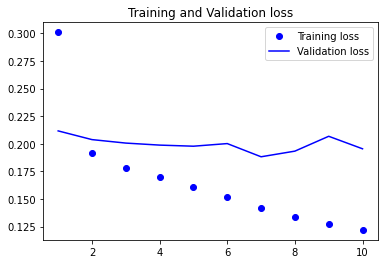

In [11]:
plot(history)

In [12]:
predictions = model.predict(x_test)

In [13]:
def test_validation(predictions, y_test=None):
    result = []
    for _ in predictions:
        result.append(int(np.round(_)))
    prediction = np.array(result)
    try:
        print('该模型准确率：{}%'.format(str(round(sum(y_test == prediction)/len(y_test),4)*100)))
    except:
        return prediction

test_validation(predictions,y_test)

该模型准确率：92.64%


In [15]:
def show_result(path):
    data = constructor(path)
    result = processor(data)
    result = preprocessing.sequence.pad_sequences(result, maxlen=maxlen)
    predictions = model.predict(result)
    prediction = test_validation(predictions)
    with open(path,'r',encoding='gbk',errors='ignore') as f:  #txt为ANSI格式
        df = []
        for line in f.readlines():
            df.append(line.strip().split('\t'))
        data = pd.DataFrame(df)
        f.close()
        for _,label,prob in zip(data[0],prediction, predictions):
            print(_, '正向评论' if label==1 else '负向评论','正向度：'+str(round((prob[0])*100,2))+'%')
    return

show_result('D:/娱乐交接文档/MD明星指数模型/可视化项目/mightUse/test_sample.txt')

这条博文太赞啦！ 正向评论 正向度：97.21%
矮油，上头版了? //@瓦力城市漫??:这个。。压力更大了。。丑媳妇终于见了公婆[嘻嘻][哈哈][给力]。亲们可不要嫌弃我啊。[泪][泪][泪][泪] 负向评论 正向度：20.07%
人弱被人欺[怒] //@黄西Joe_Wong: 所有的人，中国人和美国人在内，都应该读一下这个发自肺腑的讲演。美国20年发现越来越多的现象只能用种族主义来解释！ //@Libra- 负向评论 正向度：23.95%


D:\miniconda\envs\dl-pytorch-1.7.0\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [16]:
def real_time_show(strs):
    sample = strs
    sample_data = []
    for _ in sample:
        sample_data.append(hashmap.get(_))
    sample_data = list(filter(None, sample_data)) #中文字符的，。不包含在内
    result = preprocessing.sequence.pad_sequences([sample_data], maxlen=maxlen)
    predictions = model.predict(result)
    prediction = test_validation(predictions)
    probability = predictions[0][0]
    print('正向评论' if np.round(prediction[0]) == 1 else '负向评论','正向度：'+ \
          str(round(probability*100,1)) + '%',sep='\n')
    return

#原博文链接：https://s.weibo.com/weibo?q=%E6%88%91%E8%AE%A4%E7%9C%9F%E9%97%AE%E9%97%AE%E5%95%8A
real_time_show('我认真问问啊，我爸是演员，他演的戏播一部喊一部好烂看不下去我不想看，\
                那在追什么，追空气吗[哆啦A梦害怕]更何况小花园真的可圈可点吧，\
                我最开始也不抱什么希望打开的啊现在不带滤镜也觉得真挺好看的，\
                而且小花园是我爸第一部上星剧对他后续发展真的挺重要的……可能我就是追星洁癖吧，\
                我不知道你们怎么定义的，反正我觉得只嗑糖跟糖无关的都没什么兴趣真的在把他俩当嗑糖工具人')

负向评论
正向度：17.5%


In [17]:
#原博文链接：https://s.weibo.com/weibo?q=%E7%94%B1%E5%90%B4%E7%8F%8A%E5%8D%93%E5%8F%82%E4%B8%8E%E9%85%8D%E9%9F%B3%E7%9A%84%E7%9A%AE%E5%85%8B%E6%96%AF
real_time_show('由吴珊卓参与配音的皮克斯最新动画《青春变形记》今天在全球Disney+平台正式上线，\
                烂番茄新鲜度95%，MTC 85分，口碑十分优秀，不上院线十分可惜。\
                （所以好片都上流媒体，烂片才给院线？')

正向评论
正向度：89.7%


In [18]:
#还原原文
def get_keys(d, value):
    return [k for k,v in d.items() if v == value]

strs = ""
for i in x_test[-2]:
    try:
        strs += str(get_keys(hashmap,i)[0])
    except:
        pass
strs

'[吃惊]//@李开复:[晕]'